In [24]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import os
import math
from decimal import Decimal
import matplotlib.pyplot as plt
import numpy as np
import datetime
from multiprocessing import Process, Queue
import time
from tqdm import tqdm


# load dataset

In [41]:
##Loading data
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class DIV2K(Dataset):
    def __init__(self, root_dir, train=True, transform=None, lr_transform=None, only_lr=False):
        self.root_dir = root_dir
        self.transform = transform
        self.lr_transform = lr_transform
        self.train = train
        self.only_lr = only_lr
        self.hr_image_paths, self.lr_image_paths = self._load_image_paths()

    def _load_image_paths(self):
        if self.train:
            hr_dir_name = 'DIV2K_train_HR'
        else:
            hr_dir_name = 'DIV2K_valid_HR'
        
        hr_dir_path = os.path.join(self.root_dir, hr_dir_name)
        lr_dir_path = os.path.join(self.root_dir, hr_dir_name)
        
        lr_image_paths = sorted([os.path.join(lr_dir_path, fname) for fname in os.listdir(lr_dir_path) if fname.endswith('.png')])
        
        if not self.only_lr:
            hr_image_paths = sorted([os.path.join(hr_dir_path, fname) for fname in os.listdir(hr_dir_path) if fname.endswith('.png')])
            print(f"HR images: {len(hr_image_paths)}, LR images: {len(lr_image_paths)}")
        else:
            hr_image_paths = [None] * len(lr_image_paths)
            print(f"LR images: {len(lr_image_paths)} (HR images not loaded)")
      
        return hr_image_paths, lr_image_paths

    def __len__(self):
        return len(self.lr_image_paths)

    def __getitem__(self, idx):
        lr_img_path = self.lr_image_paths[idx]
        lr_image = Image.open(lr_img_path).convert('RGB')
        
        if self.lr_transform:
            lr_image = self.lr_transform(lr_image)
        else:
            lr_image = transforms.ToTensor()(lr_image)
        
        if not self.only_lr:
            hr_img_path = self.hr_image_paths[idx]
            hr_image = Image.open(hr_img_path).convert('RGB')
            if self.transform:
                hr_image = self.transform(hr_image)
            else:
                hr_image = transforms.ToTensor()(hr_image)
            return lr_image, hr_image
        else:
            return lr_image
        


# Define transformations
transform1 = transforms.Compose([
    transforms.Resize((128,128)),  # Resize images to 128
    transforms.ToTensor(),
])
transform2 = transforms.Compose([
    transforms.Resize((64,64)),  # Resize images to 32
    transforms.Resize((128,128), interpolation=Image.BICUBIC),  # Resize LR to match HR size
    transforms.ToTensor(),

])


# Load training dataset
train_dataset = DIV2K(root_dir='', train=True, transform=transform1, lr_transform=transform2)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Load validation dataset
val_dataset = DIV2K(root_dir='', train=False, transform=transform1, lr_transform=transform2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# # Load test dataset
test_dataset = DIV2K(root_dir='Test', transform=transform1, lr_transform=transform2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

HR images: 800, LR images: 800
HR images: 100, LR images: 100
HR images: 5, LR images: 5


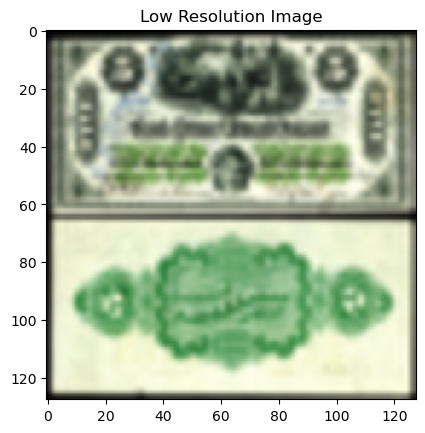

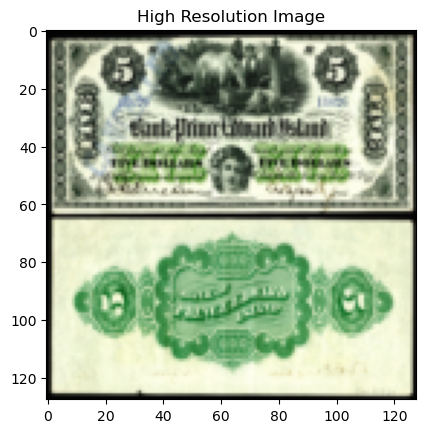

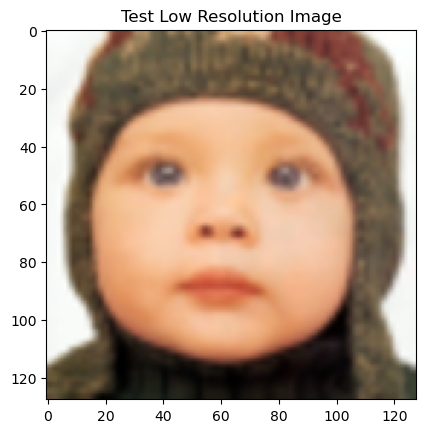

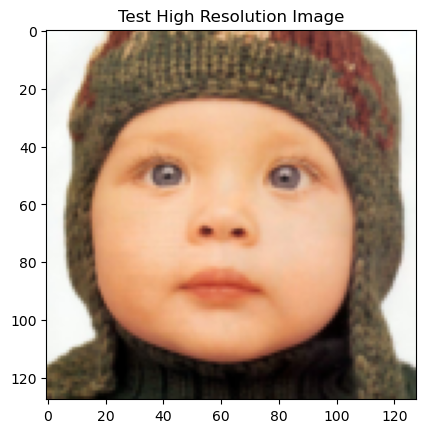

In [42]:

import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Function to denormalize and display an image
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.show()

# Get a batch of images
dataiter = iter(train_loader)
lr_images, hr_images = next(dataiter)

dataiter2 = iter(test_loader)
lr_images2, hr_images2 = next(dataiter2)

# Show the first low-resolution and high-resolution images
imshow(lr_images[0], title='Low Resolution Image')
imshow(hr_images[0], title='High Resolution Image')
imshow(lr_images2[0], title='Test Low Resolution Image')
imshow(hr_images2[0], title='Test High Resolution Image')

In [57]:
lr_images[0].size()

torch.Size([3, 128, 128])

## Model Architecture

In [29]:
import torch
import torch.nn as nn

class VDSR_model(nn.Module):
    def __init__(self) -> None:
        super(VDSR_model, self).__init__()
        self.conv_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv_2_to_19 = nn.Sequential()
        for i in range(2, 20):
            self.conv_2_to_19.add_module(f"conv_{i}", nn.Conv2d(64, 64, 3, padding=1))
            self.conv_2_to_19.add_module(f"relu_{i}", nn.ReLU())
        self.conv_20 = nn.Conv2d(64, 3, 3, padding=1)
        self.init_weights()

    def forward(self, X_in):
        x_in = X_in.clone()
        x = self.conv_1(X_in)
        torch.relu_(x)
        x = self.conv_2_to_19(x)
        x = self.conv_20(x)
        x = torch.add(x, x_in)
        x = torch.clip(x, 0.0, 1.0)
        return x

    def init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_normal_(layer.weight)

model = VDSR_model()

## Training Loop

In [30]:
import torch
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim
import numpy as np

#quantize output image 
def quantize(img, rgb_range):
    pixel_range = 255 / rgb_range
    return img.mul(pixel_range).clamp(0, 255).round().div(pixel_range)
def calc_psnr(sr, hr, rgb_range):
    diff = (sr - hr) / rgb_range
    mse = diff.pow(2).mean()
    return -10 * torch.log10(mse)

def calc_ssim(sr, hr, win_size=3):
    # Iterate over the batch dimension
    ssim_values = []
    for i in range(sr.size(0)):
        sr_np = sr[i].cpu().detach().numpy().transpose(1, 2, 0)  # Detach before converting to numpy
        hr_np = hr[i].cpu().detach().numpy().transpose(1, 2, 0)  
        ssim_value = ssim(sr_np, hr_np, multichannel=True, data_range=sr_np.max() - sr_np.min(), win_size=win_size)
        ssim_values.append(ssim_value)
    
    # Return the average SSIM over the batch
    return np.mean(ssim_values)
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
    def forward(self, sr, hr):
        # Calculate the squared difference
        loss = torch.pow(sr - hr, 2)
        # Sum the loss and multiply by 12
        return 12 * loss.mean()


In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    model.to(device)
    psnr_list = []
    ssim_list = []
    perceptual_index_list = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        for lr, hr in train_loader:
            lr, hr = lr.to(device), hr.to(device)        
            # Forward pass
            sr = model(lr)
            loss = criterion(sr, hr)  
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        running_psnr = 0.0
        running_ssim = 0.0
        with torch.no_grad():
            for lr, hr in val_loader:
                lr, hr = lr.to(device), hr.to(device)
                
                # Forward pass
                sr = model(lr)
                loss = criterion(sr, hr)
                
                running_val_loss += loss.item()
                
                # Calculate PSNR and SSIM
                psnr = calc_psnr(sr, hr, rgb_range=1)
                ssim_value = calc_ssim(sr, hr)
                running_psnr += psnr.item()
                running_ssim += ssim_value
        
        avg_val_loss = running_val_loss / len(val_loader)
        avg_psnr = running_psnr / len(val_loader)
        avg_ssim = running_ssim / len(val_loader)
        perceptual_index = (10 - avg_ssim) / 2 + (10 - avg_psnr) / 2

        psnr_list.append(avg_psnr)
        ssim_list.append(avg_ssim)
        perceptual_index_list.append(perceptual_index)

        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_psnr:.2f} dB, SSIM: {avg_ssim:.4f}, Perceptual Index: {perceptual_index:.4f}')

    return psnr_list, ssim_list, perceptual_index_list

model = VDSR_model()

# Define the L1 loss function
criterion = CustomLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

psnr_list, ssim_list, perceptual_index_list = train_and_validate(model, train_loader, val_loader, criterion, optimizer)

Epoch [1/50], Training Loss: 0.0667, Validation Loss: 0.0296, PSNR: 26.24 dB, SSIM: 0.8614, Perceptual Index: -3.5515
Epoch [2/50], Training Loss: 0.0271, Validation Loss: 0.0291, PSNR: 26.32 dB, SSIM: 0.8633, Perceptual Index: -3.5933
Epoch [3/50], Training Loss: 0.0267, Validation Loss: 0.0287, PSNR: 26.39 dB, SSIM: 0.8646, Perceptual Index: -3.6273
Epoch [4/50], Training Loss: 0.0263, Validation Loss: 0.0283, PSNR: 26.46 dB, SSIM: 0.8661, Perceptual Index: -3.6612
Epoch [5/50], Training Loss: 0.0259, Validation Loss: 0.0279, PSNR: 26.52 dB, SSIM: 0.8675, Perceptual Index: -3.6938
Epoch [6/50], Training Loss: 0.0255, Validation Loss: 0.0275, PSNR: 26.58 dB, SSIM: 0.8688, Perceptual Index: -3.7255
Epoch [7/50], Training Loss: 0.0252, Validation Loss: 0.0271, PSNR: 26.64 dB, SSIM: 0.8700, Perceptual Index: -3.7557
Epoch [8/50], Training Loss: 0.0248, Validation Loss: 0.0268, PSNR: 26.70 dB, SSIM: 0.8712, Perceptual Index: -3.7844
Epoch [9/50], Training Loss: 0.0245, Validation Loss: 0.

In [36]:
torch.save(model.state_dict(), '/Users/qichen/deep-machine-learning/project/VDSR/VDSR_model_weights.pth')

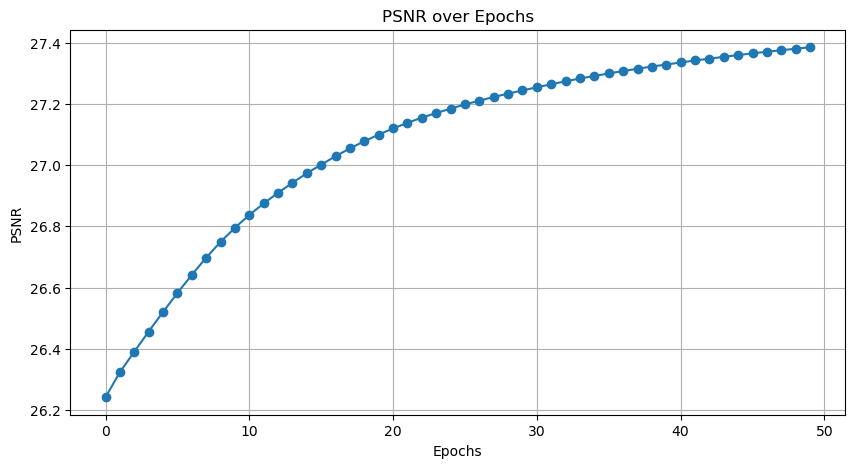

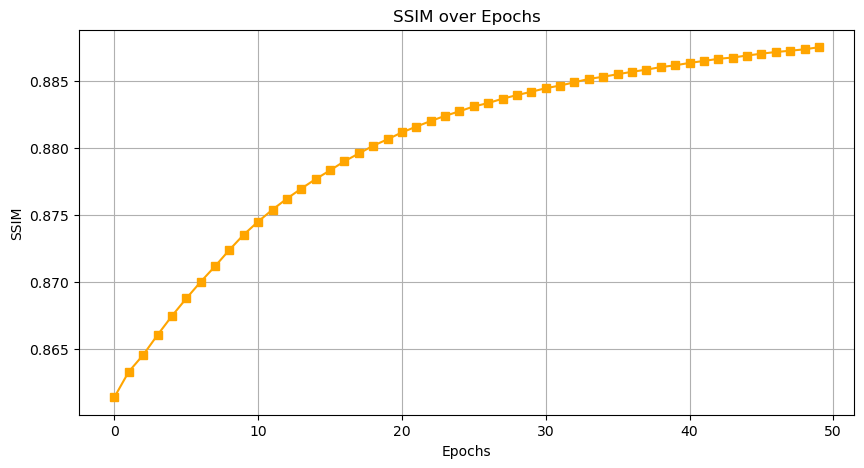

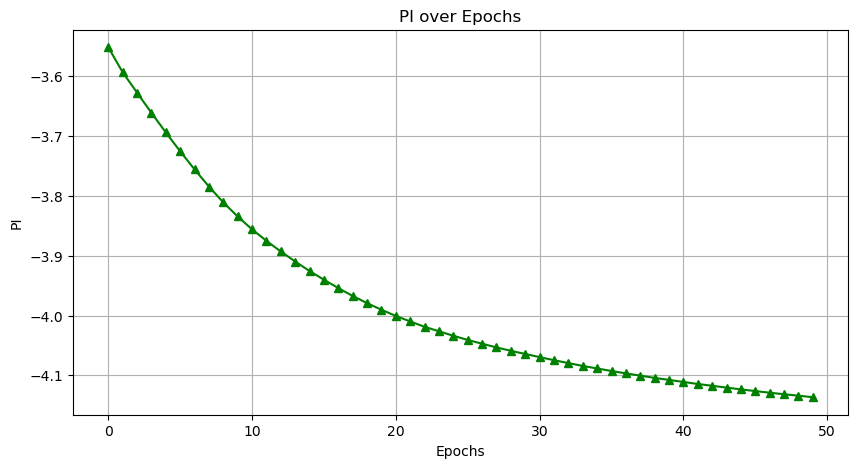

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Plot PSNR
plt.figure(figsize=(10, 5))
plt.plot(psnr_list, label='PSNR', marker='o')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.title('PSNR over Epochs')
plt.grid(True)
plt.show()

# Plot SSIM
plt.figure(figsize=(10, 5))
plt.plot(ssim_list, label='SSIM', marker='s', color='orange')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.title('SSIM over Epochs')
plt.grid(True)
plt.show()

# Plot PI
plt.figure(figsize=(10, 5))
plt.plot(perceptual_index_list, label='PI', marker='^', color='green')
plt.xlabel('Epochs')
plt.ylabel('PI')
plt.title('PI over Epochs')
plt.grid(True)
plt.show()

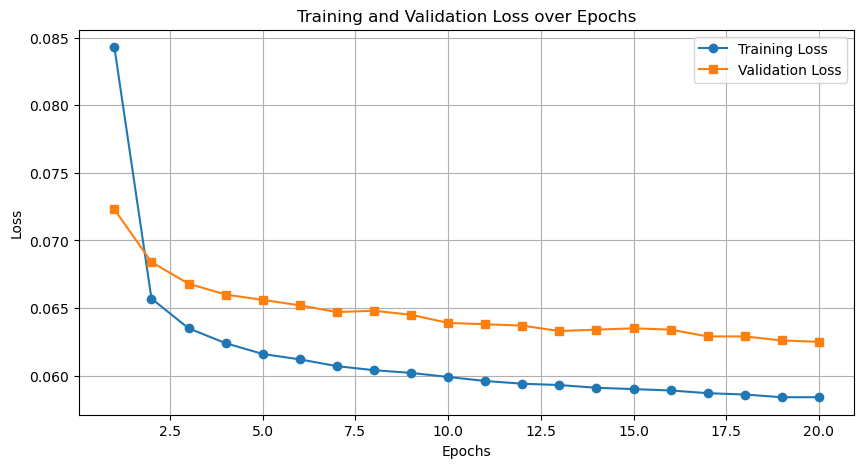

In [21]:
import matplotlib.pyplot as plt

training_losses = [
    0.0843, 0.0657, 0.0635, 0.0624, 0.0616, 0.0612, 0.0607, 0.0604, 0.0602, 0.0599,
    0.0596, 0.0594, 0.0593, 0.0591, 0.0590, 0.0589, 0.0587, 0.0586, 0.0584, 0.0584
]
validation_losses = [
    0.0723, 0.0684, 0.0668, 0.0660, 0.0656, 0.0652, 0.0647, 0.0648, 0.0645, 0.0639,
    0.0638, 0.0637, 0.0633, 0.0634, 0.0635, 0.0634, 0.0629, 0.0629, 0.0626, 0.0625
]

epochs = range(1, 21)

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss', marker='o')
plt.plot(epochs, validation_losses, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Test Images

In [38]:
model.load_state_dict(torch.load('/Users/qichen/deep-machine-learning/project/VDSR/VDSR_model_weights.pth'))
model.eval() 

VDSR_model(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2_to_19): Sequential(
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_2): ReLU()
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_3): ReLU()
    (conv_4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_4): ReLU()
    (conv_5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_5): ReLU()
    (conv_6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_6): ReLU()
    (conv_7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_7): ReLU()
    (conv_8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_8): ReLU()
    (conv_9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_9): ReLU()
    (conv_10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

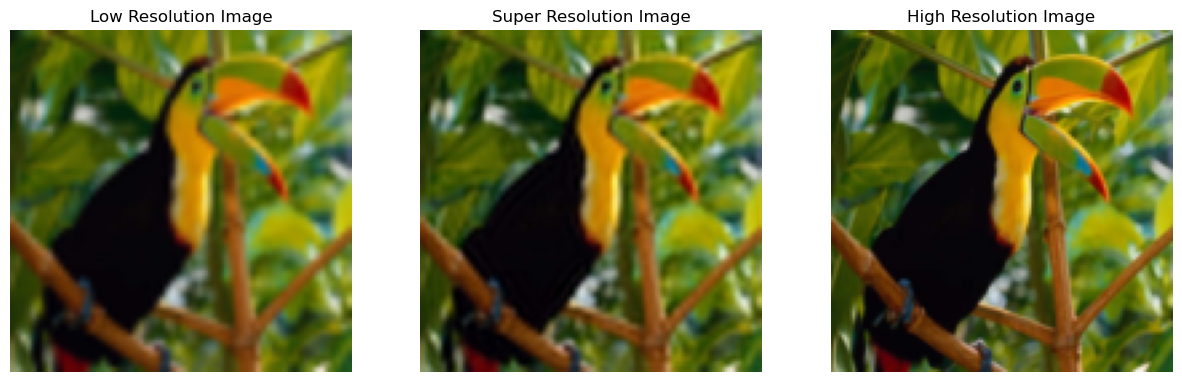

Test Loss: 0.0125, PSNR: 29.82 dB, SSIM: 0.9574, Perceptual Index: -5.3873


In [52]:
import matplotlib.pyplot as plt

def imshow_row(images, titles=None):
    """Display a list of images in a single row."""
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    if titles is None:
        titles = [None] * num_images
    for ax, img, title in zip(axes, images, titles):
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img)
        if title:
            ax.set_title(title)
        ax.axis('off')
    plt.show()

def test_model(model, test_loader, criterion):
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    with torch.no_grad():
        for lr, hr in test_loader:
            lr, hr = lr.to(device), hr.to(device)
            
            # Forward pass
            sr = model(lr)
            loss = criterion(sr, hr)
            
            running_val_loss += loss.item()
            
            # Calculate PSNR and SSIM
            psnr = calc_psnr(sr, hr, rgb_range=1)
            ssim_value = calc_ssim(sr, hr)
            running_psnr += psnr.item()
            running_ssim += ssim_value
    
    avg_test_loss = running_val_loss / len(test_loader)
    avg_psnr = running_psnr / len(test_loader)
    avg_ssim = running_ssim / len(test_loader)
    perceptual_index = (10 - avg_ssim) / 2 + (10 - avg_psnr) / 2

    # Visualize the first low-resolution, super-resolution, and high-resolution images
    imshow_row([lr[1].cpu(), sr[1].cpu(), hr[1].cpu()], 
               titles=['Low Resolution Image', 'Super Resolution Image', 'High Resolution Image'])
    
    print(f'Test Loss: {avg_test_loss:.4f}, PSNR: {avg_psnr:.2f} dB, SSIM: {avg_ssim:.4f}, Perceptual Index: {perceptual_index:.4f}')

    return avg_test_loss, avg_psnr, avg_ssim, perceptual_index

test_loss, test_psnr, test_ssim, test_perceptual_index = test_model(model, test_loader, criterion)

## Computational efficiency

In [56]:
import time

model = VDSR_model()
model.load_state_dict(torch.load('/Users/qichen/deep-machine-learning/project/VDSR/VDSR_model_weights.pth'))
model.eval()

 

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
vdsr_params = count_parameters(model)
print(f"VDSR Parameters: {vdsr_params}")

def measure_inference_time(model, input_tensor):
    start_time = time.time()
    with torch.no_grad():
        model(input_tensor)
    end_time = time.time()
    return (end_time - start_time) * 1000  # Convert to milliseconds

# Create a sample input tensor
sample_input = torch.rand(1, 3, 128, 128)  # Adjust dimensions as needed
vdsr_time = measure_inference_time(model, sample_input)
print(f"VDSR Inference Time: {vdsr_time:.2f} ms")

from memory_profiler import memory_usage

def measure_memory_usage(model, input_tensor):
    # Define a function to run the model
    def run_model():
        with torch.no_grad():
            model(input_tensor)
    # Measure memory usage
    mem_usage = memory_usage(run_model)
    return max(mem_usage) - min(mem_usage)  # Return the difference in memory usage
sample_input = torch.rand(1, 3, 128, 128)

# Measure memory usage
memory_used = measure_memory_usage(model, sample_input)
print(f"Memory usage during inference: {memory_used:.2f} MB")

VDSR Parameters: 668227
VDSR Inference Time: 136.63 ms
Memory usage during inference: 6.02 MB
